<a href="https://colab.research.google.com/github/elegant/forecasting/blob/main/timegpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset

In [ ]:
api_token = {"username":"", "key":""}

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

import json
with open("/root/.kaggle/kaggle.json", "w") as file:
    json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c m5-forecasting-accuracy
!unzip m5-forecasting-accuracy.zip

 85% 39.0M/45.8M [00:00<00:00, 217MB/s]
100% 45.8M/45.8M [00:00<00:00, 213MB/s]
Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         


In [ ]:
# calendar.csv - Contains information about the dates on which the products are sold.
# sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
# sell_prices.csv - Contains information about the price of the products sold per store and date.
# sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

# sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
# -
# Each row contains an id that is a concatenation of an item_id and a store_id, which is either validation (corresponding to the Public leaderboard)
# , or evaluation (corresponding to the Private leaderboard). You are predicting 28 forecast days (F1-F28) of items sold for each row. For
# the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969. (Note: a month
# before the competition close, the ground truth for the validation rows will be provided.)

In [ ]:
import pandas as pd

In [ ]:
calendar = pd.read_csv("calendar.csv")
sales_train_validation = pd.read_csv("sales_train_validation.csv")
sell_prices = pd.read_csv("sell_prices.csv")
sample_submission = pd.read_csv("sample_submission.csv")
sales_train_evaluation = pd.read_csv("sales_train_evaluation.csv")

# EDA

## Data prep. (df_store)

In [ ]:
df = sales_train_evaluation.groupby("store_id").sum().iloc[:, 5:]
df

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,4951,6245,6707,4568,3949,3995,4136,4433,5764,6289
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4839,6507,6710,4238,3963,3789,4037,4751,7120,6614
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6046,7029,7969,5891,5523,5375,5580,5542,7073,8144
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2635,3256,3318,3024,2715,2519,2544,2704,3146,3597
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3610,3787,5000,3708,3310,3147,2748,3664,4167,4624
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,4415,4424,5866,4179,4008,3518,3126,4249,4802,5217
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,4295,4155,5383,4341,4052,3710,3288,4390,4712,4974
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3978,5527,5488,3505,3323,3242,3478,3813,5002,5054
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,5317,7704,7586,5011,4628,4533,4628,4880,5213,5068


In [ ]:
df_transposed = df.T
df_transposed["d"] = df_transposed.index
df_transposed

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5
...,...,...,...,...,...,...,...,...,...,...,...
d_1937,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268,d_1937
d_1938,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398,d_1938
d_1939,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126,d_1939
d_1940,5764,7120,7073,3146,4167,4802,4712,5002,5213,4519,d_1940


In [ ]:
df_store = pd.merge(df_transposed, calendar, how="left", left_on="d", right_on="d")
df_store["date"] = pd.to_datetime(df_store["date"])
df_store

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,3995,3789,5375,2519,3147,3518,3710,3242,4533,3268,...,5,5,2016,NaN,NaN,NaN,NaN,0,0,0
1937,4136,4037,5580,2544,2748,3126,3288,3478,4628,3398,...,6,5,2016,NaN,NaN,NaN,NaN,0,0,0
1938,4433,4751,5542,2704,3664,4249,4390,3813,4880,4126,...,7,5,2016,NaN,NaN,NaN,NaN,0,0,0
1939,5764,7120,7073,3146,4167,4802,4712,5002,5213,4519,...,1,5,2016,NaN,NaN,NaN,NaN,0,0,0


In [ ]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1941 entries, 0 to 1940
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CA_1          1941 non-null   int64         
 1   CA_2          1941 non-null   int64         
 2   CA_3          1941 non-null   int64         
 3   CA_4          1941 non-null   int64         
 4   TX_1          1941 non-null   int64         
 5   TX_2          1941 non-null   int64         
 6   TX_3          1941 non-null   int64         
 7   WI_1          1941 non-null   int64         
 8   WI_2          1941 non-null   int64         
 9   WI_3          1941 non-null   int64         
 10  d             1941 non-null   object        
 11  date          1941 non-null   datetime64[ns]
 12  wm_yr_wk      1941 non-null   int64         
 13  weekday       1941 non-null   object        
 14  wday          1941 non-null   int64         
 15  month         1941 non-null   int64   

In [ ]:
store_ids = df_store.columns[:10]
store_ids

Index(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2',
       'WI_3'],
      dtype='object')

# TimeGPT

In [ ]:
api_key_nixtla =""

## At level 'store'

In [ ]:
!pip install -q nixtla

In [ ]:
from nixtla import NixtlaClient
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
nixtla_client = NixtlaClient(
    api_key = api_key_nixtla
)
nixtla_client.validate_api_key()


True

In [ ]:
print(df_store.shape)
df_store.head()

(1941, 24)


,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
#df_store.columns
columns_list = ["d", "date", "wm_yr_wk", "weekday", "wday", "month", "year",
       "event_name_1", "event_type_1", "event_name_2", "event_type_2",
       "snap_CA", "snap_TX", "snap_WI"]

store_id = "CA_1"
df_store_particular = df_store[[store_id]+ columns_list].copy()
df_store_particular.head()

,CA_1,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


In [ ]:
for colname in df_store_particular.columns:
  print("*"*50)
  print(colname)
  print("*"*50)
  print(df_store_particular[colname].value_counts(dropna=False))

**************************************************
CA_1
**************************************************
CA_1
4018    5
0       5
3818    5
3843    5
3702    4
       ..
4441    1
4817    1
2886    1
5075    1
6289    1
Name: count, Length: 1476, dtype: int64
**************************************************
d
**************************************************
d
d_1       1
d_1276    1
d_1304    1
d_1303    1
d_1302    1
         ..
d_643     1
d_642     1
d_641     1
d_640     1
d_1941    1
Name: count, Length: 1941, dtype: int64
**************************************************
date
**************************************************
date
2011-01-29    1
2014-07-27    1
2014-08-24    1
2014-08-23    1
2014-08-22    1
             ..
2012-11-01    1
2012-10-31    1
2012-10-30    1
2012-10-29    1
2016-05-22    1
Name: count, Length: 1941, dtype: int64
**************************************************
wm_yr_wk
**************************************************
wm_yr_wk
11101    7
1

In [ ]:
df_store_particular.describe()

,CA_1,date,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI
count,1941.000000,1941,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000,1941.000000
mean,4035.161257,2013-09-25 00:00:00,11343.166924,3.997424,6.334879,2013.249356,0.329727,0.329727,0.329727
min,0.000000,2011-01-29 00:00:00,11101.000000,1.000000,1.000000,2011.000000,0.000000,0.000000,0.000000
25%,3359.000000,2012-05-28 00:00:00,11218.000000,2.000000,3.000000,2012.000000,0.000000,0.000000,0.000000
50%,3918.000000,2013-09-25 00:00:00,11335.000000,4.000000,6.000000,2013.000000,0.000000,0.000000,0.000000
75%,4653.000000,2015-01-23 00:00:00,11451.000000,6.000000,9.000000,2015.000000,1.000000,1.000000,1.000000
max,6948.000000,2016-05-22 00:00:00,11617.000000,7.000000,12.000000,2016.000000,1.000000,1.000000,1.000000
std,994.891371,NaN,152.899023,2.001158,3.440086,1.557375,0.470235,0.470235,0.470235


In [ ]:
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()

qualitative_cols = ["event_name_1", "event_type_1", "event_name_2", "event_type_2"]
for colname in qualitative_cols:
  print(colname)
  df_store_particular[colname] = le.fit_transform(df_store_particular[colname])

df_store_particular.head()

event_name_1
event_type_1
event_name_2
event_type_2


,CA_1,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,d_1,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0
1,4155,d_2,2011-01-30,11101,Sunday,2,1,2011,30,4,4,2,0,0,0
2,2816,d_3,2011-01-31,11101,Monday,3,1,2011,30,4,4,2,0,0,0
3,3051,d_4,2011-02-01,11101,Tuesday,4,2,2011,30,4,4,2,1,1,0
4,2630,d_5,2011-02-02,11101,Wednesday,5,2,2011,30,4,4,2,1,0,1


In [ ]:
train_numbers = np.arange(1, 1886)
valid_numbers = np.arange(1886, 1914)
test_numbers = np.arange(1914, 1942)

train_days = ["d_"+str(num) for num in train_numbers]
valid_days = ["d_"+str(num) for num in valid_numbers]
test_days = ["d_"+str(num) for num in test_numbers]

days_list = train_days + valid_days + test_days

df_train_valid_test = pd.DataFrame({"d": days_list, "data_type": ["train"]*len(train_numbers) + ["valid"]*len(valid_numbers) + ["test"]*len(test_numbers)})
df_train_valid_test

,d,data_type
0,d_1,train
1,d_2,train
2,d_3,train
3,d_4,train
4,d_5,train
...,...,...
1936,d_1937,test
1937,d_1938,test
1938,d_1939,test
1939,d_1940,test


In [ ]:
df_store_particular2 = pd.merge(df_store_particular, df_train_valid_test, how="left", left_on="d", right_on="d")
df_store_particular2.head()

,CA_1,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,data_type
0,4337,d_1,2011-01-29,11101,Saturday,1,1,2011,30,4,4,2,0,0,0,train
1,4155,d_2,2011-01-30,11101,Sunday,2,1,2011,30,4,4,2,0,0,0,train
2,2816,d_3,2011-01-31,11101,Monday,3,1,2011,30,4,4,2,0,0,0,train
3,3051,d_4,2011-02-01,11101,Tuesday,4,2,2011,30,4,4,2,1,1,0,train
4,2630,d_5,2011-02-02,11101,Wednesday,5,2,2011,30,4,4,2,1,0,1,train


In [ ]:
df_store_particular2 = df_store_particular2.drop(["d", "wm_yr_wk", "weekday"], axis=1)
df_store_particular2["unique_id"] = 0
df_store_particular2 = df_store_particular2.rename(columns={"CA_1": "y", "date": "ds"})
df_store_particular2.head()

,y,ds,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,data_type,unique_id
0,4337,2011-01-29,1,1,2011,30,4,4,2,0,0,0,train,0
1,4155,2011-01-30,2,1,2011,30,4,4,2,0,0,0,train,0
2,2816,2011-01-31,3,1,2011,30,4,4,2,0,0,0,train,0
3,3051,2011-02-01,4,2,2011,30,4,4,2,1,1,0,train,0
4,2630,2011-02-02,5,2,2011,30,4,4,2,1,0,1,train,0


In [ ]:
timegpt_train_df = df_store_particular2[df_store_particular2["data_type"]=="train"].drop("data_type", axis=1)
timegpt_valid_df = df_store_particular2[df_store_particular2["data_type"]=="valid"].drop("data_type", axis=1)
timegpt_test_df = df_store_particular2[df_store_particular2["data_type"]=="test"].drop("data_type", axis=1)
print(timegpt_train_df.shape)
print(timegpt_valid_df.shape)
print(timegpt_test_df.shape)

(1885, 13)
(28, 13)
(28, 13)


In [ ]:
timegpt_train_df.dtypes

y                        int64
ds              datetime64[ns]
wday                     int64
month                    int64
year                     int64
event_name_1             int64
event_type_1             int64
event_name_2             int64
event_type_2             int64
snap_CA                  int64
snap_TX                  int64
snap_WI                  int64
unique_id                int64
dtype: object

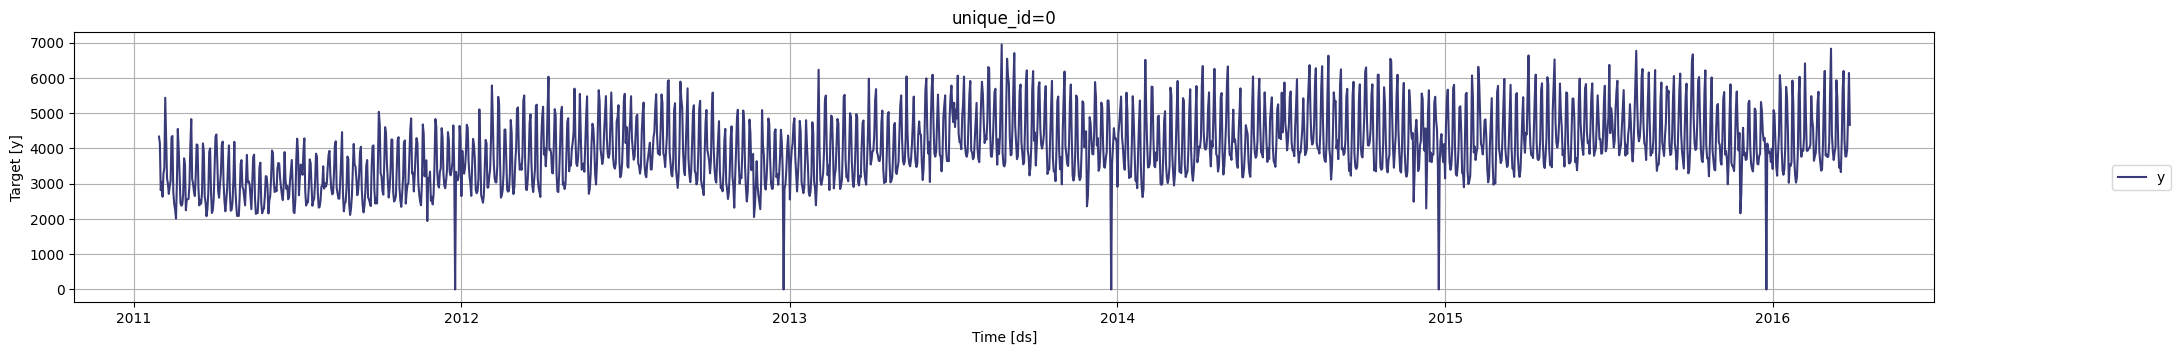

In [ ]:
nixtla_client.plot(timegpt_train_df)


In [ ]:
fcst = nixtla_client.forecast(df=timegpt_train_df, X_df=timegpt_valid_df, h=len(valid_days), freq="D")
fcst.head()


,unique_id,ds,TimeGPT
0,0,2016-03-28,3969.789889
1,0,2016-03-29,3937.531349
2,0,2016-03-30,3590.554767
3,0,2016-03-31,4242.024222
4,0,2016-04-01,4993.750452


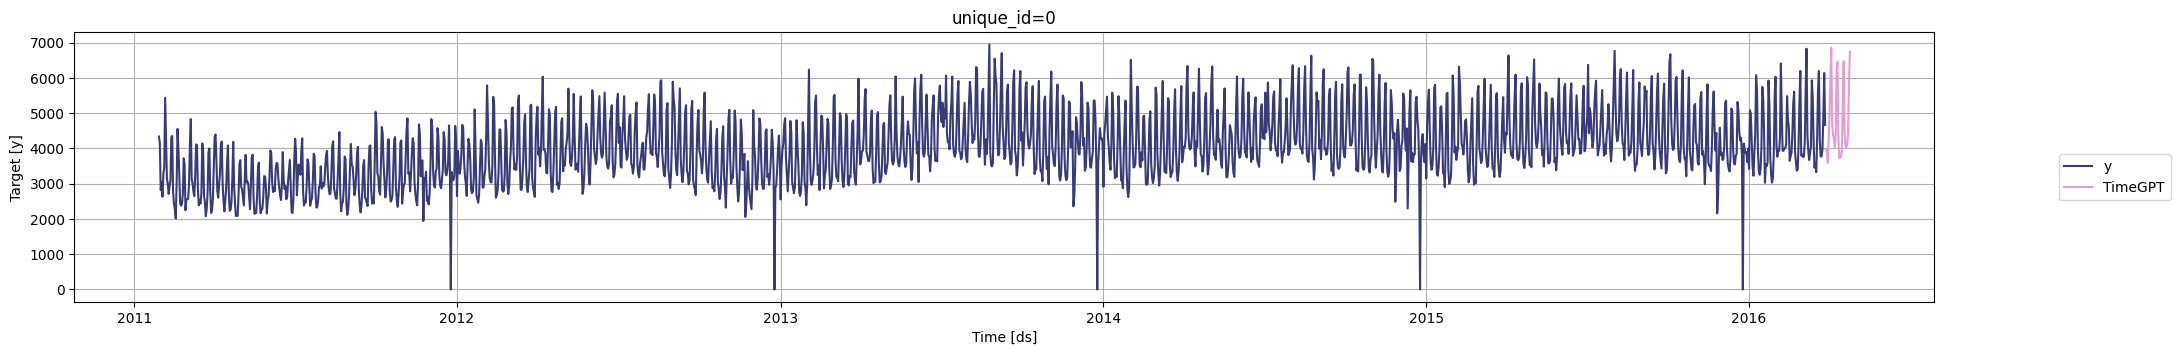

In [ ]:
nixtla_client.plot(timegpt_train_df, fcst)

In [ ]:
#Eval
timegpt_valid_df.head()

,y,ds,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,unique_id
1885,3905,2016-03-28,3,3,2016,30,4,4,2,0,0,0,0
1886,3788,2016-03-29,4,3,2016,30,4,4,2,0,0,0,0
1887,3339,2016-03-30,5,3,2016,30,4,4,2,0,0,0,0
1888,4076,2016-03-31,6,3,2016,30,4,4,2,0,0,0,0
1889,4983,2016-04-01,7,4,2016,30,4,4,2,1,1,0,0


In [ ]:
result = timegpt_valid_df[["unique_id", "ds", "y"]].copy()
result.set_index("ds", inplace=True)
result["TimeGPT_fcst"] = fcst["TimeGPT"].values
print(result.head())

            unique_id     y  TimeGPT_fcst
ds                                       
2016-03-28          0  3905   3969.789889
2016-03-29          0  3788   3937.531349
2016-03-30          0  3339   3590.554767
2016-03-31          0  4076   4242.024222
2016-04-01          0  4983   4993.750452


In [ ]:
import numpy as np


def calculate_error_metrics(actual_values, predicted_values):
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    metrics_dict = {
        "MAE": np.mean(np.abs(actual_values - predicted_values)),
        "RMSE": np.sqrt(np.mean((actual_values - predicted_values)**2)),
        "MAPE": np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        "SMAPE": 100 * np.mean(2 * np.abs(predicted_values - actual_values) / (np.abs(predicted_values) + np.abs(actual_values))),
        "MdAPE": np.median(np.abs((actual_values - predicted_values) / actual_values)) * 100,
        "GMRAE": np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))
    }

    result_df = pd.DataFrame(list(metrics_dict.items()), columns=["Metric", "Value"])
    return result_df

# Extract "y" as actuals
actuals = result["y"]


error_metrics_dict = {}


for col in result.columns[2:]:  # Exclude "y"
    predicted_values = result[col]
    error_metrics_dict[col] = calculate_error_metrics(actuals, predicted_values)["Value"].values  # Extracting "Value" column


error_metrics_df = pd.DataFrame(error_metrics_dict)
error_metrics_df.insert(0, "Metric", calculate_error_metrics(actuals, actuals)["Metric"].values)  # Adding "Metric" column


print(error_metrics_df)

  Metric  TimeGPT_fcst
0    MAE    235.769987
1   RMSE    281.573250
2   MAPE      5.230106
3  SMAPE      5.076681
4  MdAPE      4.352900
5  GMRAE      0.038001


<ipython-input-31-7f22b7691877>:14: RuntimeWarning: divide by zero encountered in log
  "GMRAE": np.exp(np.mean(np.log(np.abs(actual_values - predicted_values) / actual_values)))


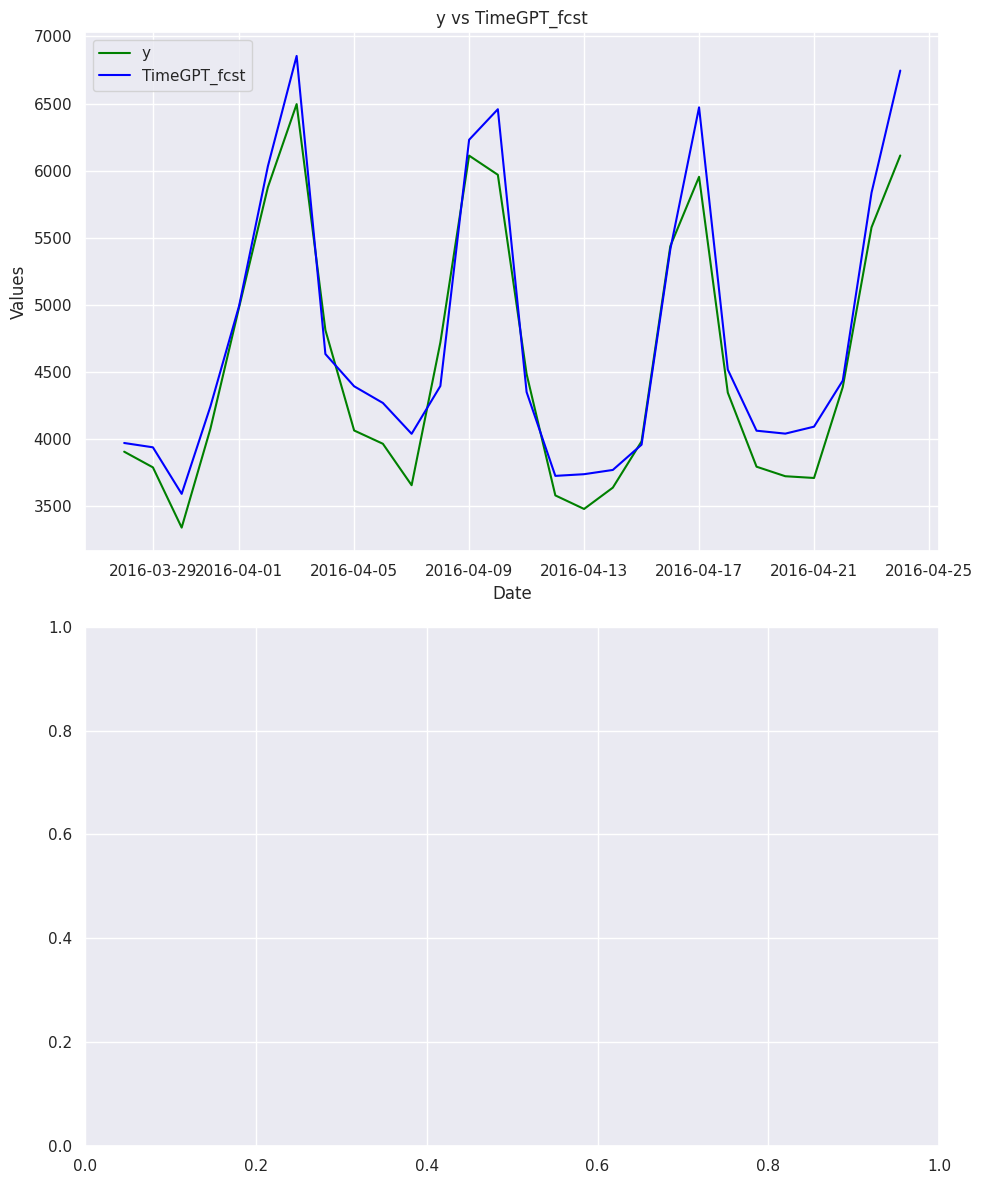

In [ ]:
#Visualizing the difference between Actuals and Predicted for each of the methods

# Set seaborn style to darkgrid
sns.set(style="darkgrid")

# Create subplots for each prediction column
num_cols = len(result.columns[1:])
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(10, 6 * num_cols))

# Loop through each prediction column and plot on separate subplot
for i, col in enumerate(result.columns[2:]):  # Exclude "y"
    axes[i].plot(result.index, result["y"], label="y", color="green")
    axes[i].plot(result.index, result[col], label=col, color="blue")
    axes[i].set_title(f"y vs {col}")
    axes[i].set_xlabel("Date")
    axes[i].set_ylabel("Values")
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
fcst_test = nixtla_client.forecast(df=pd.concat([timegpt_train_df, timegpt_valid_df]), X_df=timegpt_test_df, h=len(test_days), freq="D")
fcst_test.head()

,unique_id,ds,TimeGPT
0,0,2016-04-25,4495.748648
1,0,2016-04-26,3899.051051
2,0,2016-04-27,3839.743806
3,0,2016-04-28,3763.075459
4,0,2016-04-29,4518.341223


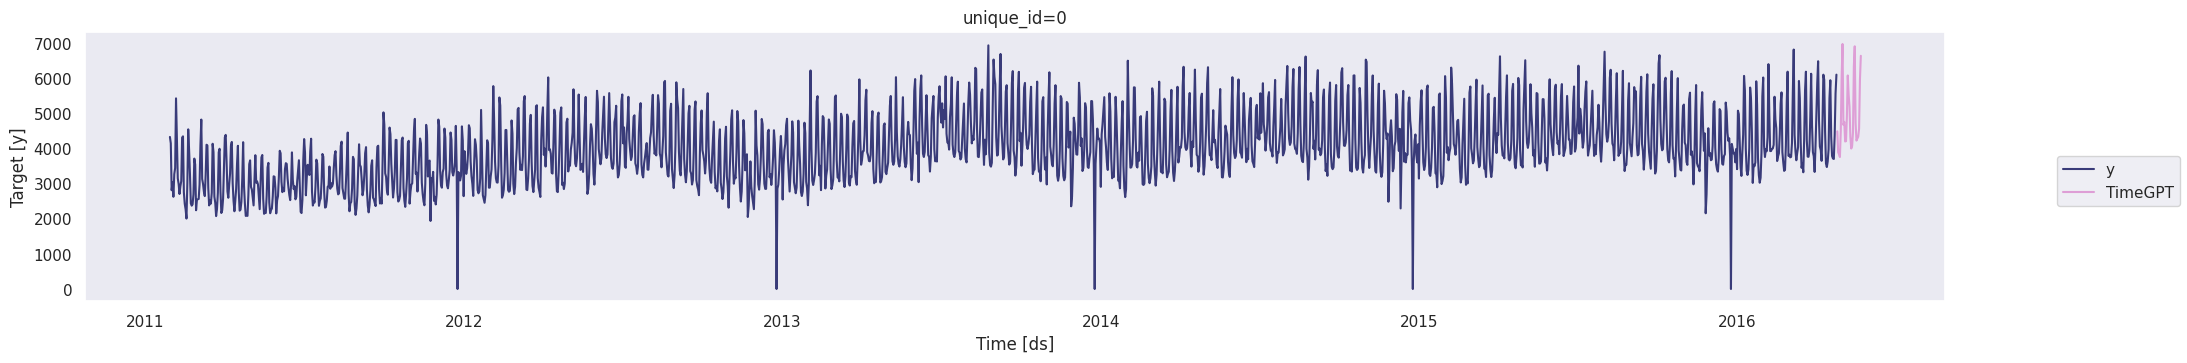

In [ ]:
nixtla_client.plot(pd.concat([timegpt_train_df, timegpt_valid_df]), fcst_test)